In [39]:
import pandas as pd
import time
import plotly.graph_objects as go 
import ast
import pickle
import networkx as nx
from collections import Counter
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
en_data = pd.read_csv("en.csv")
es_data = pd.read_csv("es.csv")

In [4]:
def convert_format(field):
    return ast.literal_eval(field)

en_data['hashtags'] = en_data['hashtags'].apply(convert_format)
en_data['links'] = en_data['links'].apply(convert_format)
en_data['mentionedUsers'] = en_data['mentionedUsers'].apply(convert_format)

es_data['hashtags'] = es_data['hashtags'].apply(convert_format)
es_data['links'] = es_data['links'].apply(convert_format)
es_data['mentionedUsers'] = es_data['mentionedUsers'].apply(convert_format)


#### Since we focus on users who engage actively, we only consider those sharing more than 3 url

In [23]:
en_data['links']

0                                                        []
1                                                        []
2                                                        []
3                                                        []
4                                                        []
                                ...                        
372952                                                   []
372953                                                   []
372954                                                   []
372955    [{'display_url': 'rawstory.com/raw-investigat…...
372956                                                   []
Name: links, Length: 372957, dtype: object

#### Network construction

In [72]:
def preprocess_urls(dataframe):
    # Extract user-URL mappings
    user_url_map = [
        (user, url['expanded_url']) 
        for user, urls in zip(dataframe['id_str'], dataframe['links'])
        if isinstance(urls, list) 
        for url in urls 
        if isinstance(url, dict) and 'expanded_url' in url and len(url['expanded_url']) != 0
    ]

    # Create a DataFrame for user-URL pairs
    user_url_df = pd.DataFrame(user_url_map, columns=["user", "url"])
    
    # Count number of valid URLs per user
    user_url_counts = user_url_df.groupby('user')['url'].count()
    users_with_min_links = user_url_counts[user_url_counts >= 3].index

    # Filter DataFrame to include only users with >= 3 URLs
    user_url_df = user_url_df[user_url_df['user'].isin(users_with_min_links)]
    # unique_users = user_url_df['user'].nunique()
    # print(f"Unique users sharing > 3 unique URLs: {unique_users}")
    
    return user_url_df


In [85]:
def construct_full_co_url_network(dataframe, min_df=3, threshold=0.6):
    # Extract and preprocess URLs
    user_url_df = preprocess_urls(dataframe)

    # Pivot the user-URL DataFrame to create a user-URL matrix
    user_url_matrix = user_url_df.pivot_table(index="user", columns="url", aggfunc=len, fill_value=0)

    # Calculate URL frequencies (column sums)
    url_frequencies = user_url_matrix.sum(axis=0)

    # Filter URLs based on min_df and max_df
    valid_urls = url_frequencies[(url_frequencies >= min_df)].index
    filtered_user_url_matrix = user_url_matrix[valid_urls]

    # Convert to sparse matrix
    user_url_sparse_matrix = csr_matrix(filtered_user_url_matrix.values)

    # Apply TF-IDF transformation
    tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
    tfidf_matrix = tfidf_transformer.fit_transform(user_url_sparse_matrix)

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Build user-user graph
    user_ids = filtered_user_url_matrix.index
    G = nx.Graph()
    for i, user1 in enumerate(user_ids):
        for j, user2 in enumerate(user_ids):
            if i != j and similarity_matrix[i, j] > threshold:
                G.add_edge(user1, user2, weight=similarity_matrix[i, j])

    return G


In [86]:
en_co_url_graph = construct_full_co_url_network(en_data)

In [87]:
en_co_url_graph.size()

202

In [ ]:
def plot_interactive_graph(G):
    # Get positions for nodes
    pos = nx.spring_layout(G, seed=42)  # Use a consistent layout for reproducibility

    # Extract node positions
    x_nodes = [pos[node][0] for node in G.nodes()]
    y_nodes = [pos[node][1] for node in G.nodes()]
    node_ids = list(G.nodes())

    # Extract edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])  # None creates breaks in the line
        edge_y.extend([y0, y1, None])

    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Create node trace
    node_trace = go.Scatter(
        x=x_nodes,
        y=y_nodes,
        mode='markers',
        text=node_ids,
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            size=[G.degree[node] * 5 for node in G.nodes()],  # Scale by degree
            color=[G.degree[node] for node in G.nodes()],
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        )
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show()

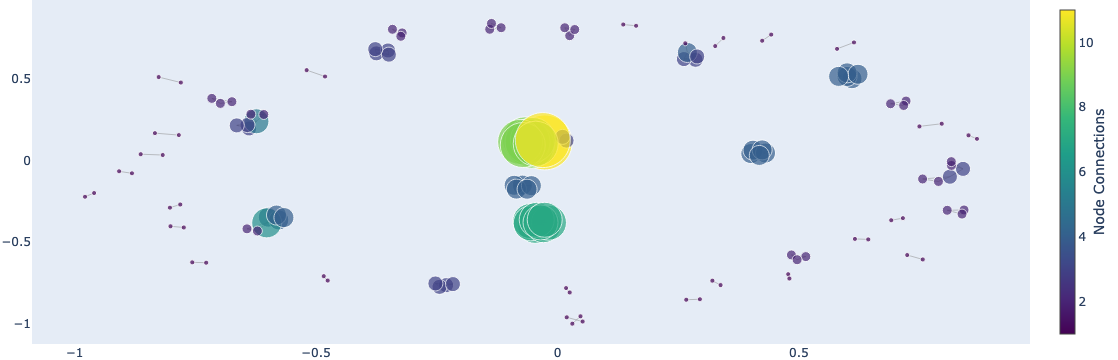

In [107]:
# Plot the interactive graph
plot_interactive_graph(en_co_url_graph)

In [105]:
eigenvector_centrality = nx.eigenvector_centrality(en_co_url_graph)

In [127]:
# nx.write_gexf(en_co_url_graph, "co_url_network.gexf")

In [115]:
Counter(eigenvector_centrality)

Counter({"'965656027327844353'": 0.3268754300369587,
         "'115469737'": 0.3268754300369586,
         "'121333842'": 0.3109030229794997,
         "'1366631'": 0.3109030229794997,
         "'1431082300201218048'": 0.3109030229794997,
         "'1523417323637403650'": 0.3109030229794997,
         "'1617273338245615617'": 0.3109030229794997,
         "'1663257700245831680'": 0.3109030229794997,
         "'1666883600241901568'": 0.3109030229794997,
         "'1774210941229363200'": 0.3109030229794997,
         "'1490793941389783043'": 0.08068260558849139,
         "'1641929188369395713'": 0.08068260558849139,
         "'1435732089777836036'": 5.3857311902970685e-05,
         "'1505941951727685636'": 5.3857311902970685e-05,
         "'15815676'": 5.3857311902970685e-05,
         "'1613996935056134160'": 5.3857311902970685e-05,
         "'1714368628617789440'": 5.3857311902970685e-05,
         "'214645076'": 5.3857311902970685e-05,
         "'2284614762'": 5.3857311902970685e-05,
       

#### Spanish

In [93]:
es_co_url_graph = construct_full_co_url_network(es_data)


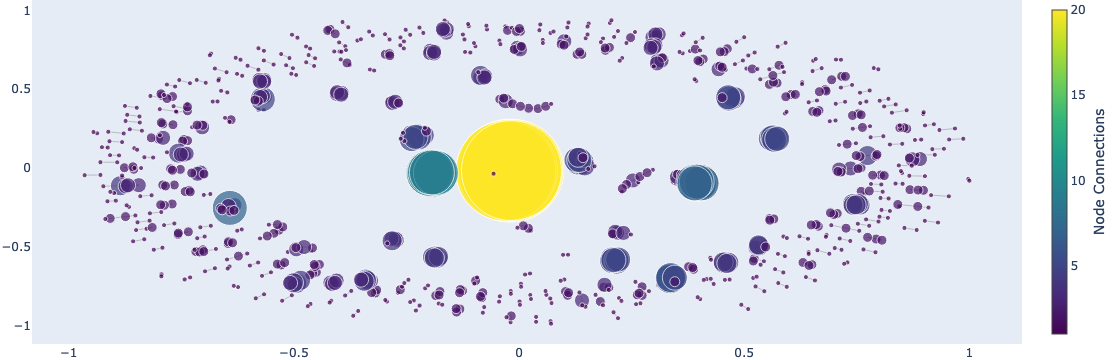

In [126]:
plot_interactive_graph(es_co_url_graph)


In [124]:
es_co_url_graph.size()

994

In [125]:
eigenvector_centrality_es = nx.eigenvector_centrality(es_co_url_graph)
Counter(eigenvector_centrality_es)

Counter({"'130602921'": 0.22083819263939425,
         "'1370085054366498816'": 0.22083819263939425,
         "'1467898322350493697'": 0.22083819263939425,
         "'1467903698693201932'": 0.22083819263939425,
         "'184562575'": 0.22083819263939425,
         "'185855764'": 0.22083819263939425,
         "'1909278404'": 0.22083819263939425,
         "'199419207'": 0.22083819263939425,
         "'2319345398'": 0.22083819263939425,
         "'259861358'": 0.22083819263939425,
         "'275534799'": 0.22083819263939425,
         "'360038125'": 0.22083819263939425,
         "'362826419'": 0.22083819263939425,
         "'36960564'": 0.22083819263939425,
         "'52878788'": 0.22083819263939425,
         "'56737658'": 0.22083819263939425,
         "'97979269'": 0.22083819263939425,
         "'74643663'": 0.21218566004754913,
         "'17584258'": 0.21166733413960634,
         "'546383985'": 0.21166733413960634,
         "'1467895590105370626'": 0.19019446737631743,
         "'14312101

In [ ]:
# Save graphs for future use
pickle.dump(en_text_graph, open('en_co_url_graph_tfidf.gpickle', 'wb'))
pickle.dump(es_text_graph, open('es_co_url_graph_tfidf.gpickle', 'wb'))


In [ ]:
# def construct_co_url_network(dataframe):
#     # 1: Extract user-URL mappings
#     user_url_map = defaultdict(list)
#     for _, row in dataframe.iterrows():
#         user = row['id_str']
#         links = row['links']
#         if isinstance(links, list):
#             for link in links:
#                 expanded_url = link.get('expanded_url')
#                 if expanded_url:
#                     user_url_map[user].append(expanded_url)

#     # 2: Create user-URL matrix (rows representing users, cols representing URLs)
#     users = list(user_url_map.keys())
#     urls = list({url for url_list in user_url_map.values() for url in url_list})
#     user_url_matrix = np.zeros((len(users), len(urls)))

#     for i, user in enumerate(users):
#         for url in user_url_map[user]:
#             if url in urls:
#                 user_url_matrix[i, urls.index(url)] = 1

#     # 3: Compute cosine similarity between users 
#     similarity_matrix = cosine_similarity(user_url_matrix)  # Calculate the cosine sim between rows (users)
 
#     # 4: Build user-user graph
#     G = nx.Graph()
#     for i, user1 in enumerate(users):
#         for j, user2 in enumerate(users):
#             if i != j and similarity_matrix[i, j] > 0.7:
#                 G.add_edge(user1, user2, weight=similarity_matrix[i, j])

#     return G